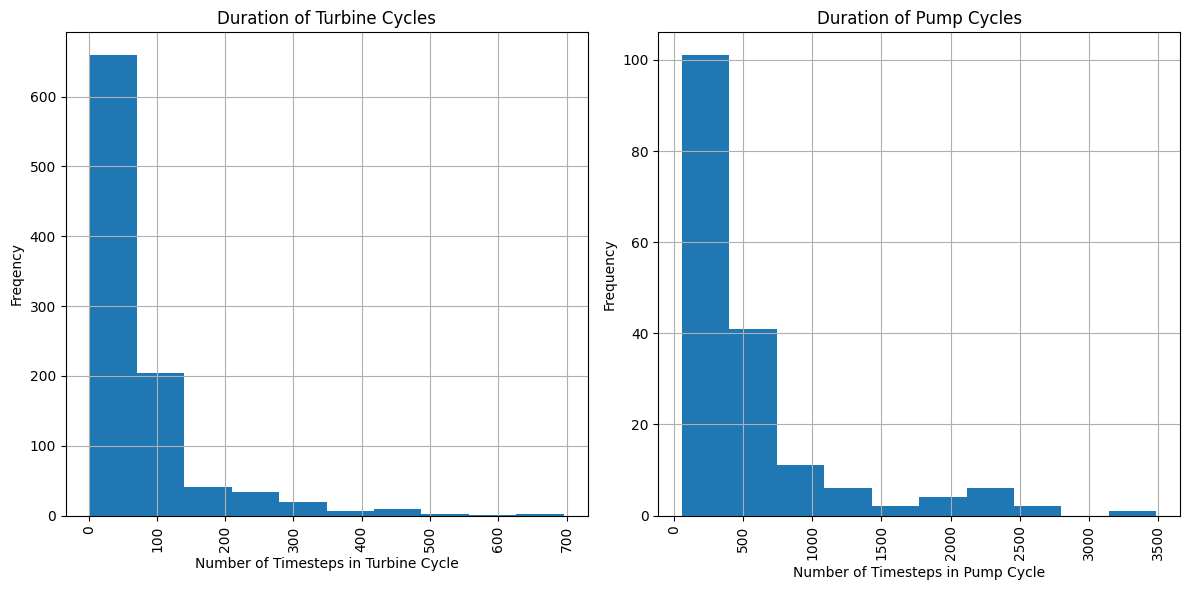

Percentage of data removed from turbine: 4.99%
Percentage of data removed from pump: 0.00%
Percentage of data removed from turbine: 1.13%
Percentage of data removed from pump: 1.01%
Percentage of data removed from turbine: 0.94%
Percentage of data removed from pump: 0.04%
u4_control_vars = ['tot_activepower', 'plant_tmp', 'ext_tmp', 'canal_tmp', 'lake_tmp', 'coupler_position', 'injector12_pressure', 'injector34_pressure', 'pump_rotspeed', 'turbine_rotspeed', 'scaled_injector_sum']
u4_measurement_vars = ['water_primary_cold_tmp', 'water_primary_hot_tmp', 'valve_opening', 'refri_bath_level', 'aspi_bath_level', 'canal_level', 'water_primary_filter_out_pressure', 'water_primary_filter_in_pressure', 'tot_reactivepower', 'exc_freq', 'exc_current', 'exc_voltage', 'powerfactor', 'elec_freq', 'ph01_current', 'ph02_current', 'ph03_current', 'ph01_voltage', 'ph12_voltage', 'ph02_voltage', 'ph23_voltage', 'ph03_voltage', 'ph31_voltage', 'machine_off', 'equilibrium_turbine_mode', 'equilibrium_pump_

In [1]:
import import_ipynb
import data_preprocessing


# Update the path to the correct location of the file
file_path = '.'

# Now you can use functions and variables from data_preprocessing
# For example, if data_preprocessing has a function named preprocess_data, you can call it like this:
# processed_data = data_preprocessing.preprocess_data(raw_data)

In [158]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import matthews_corrcoef
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")


### Code from josh_models.ipynb


In [3]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

## Import Dependencies :

In [4]:
# Install essential libraries for deep learning and data processing
%pip install torch torchvision numpy tqdm

# Install libraries for audio analysis and feature extraction
%pip install librosa

# Install libraries for visualization and plotting
%pip install matplotlib

# Install libraries for machine learning metrics
%pip install scikit-learn



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Define Auto Encoder


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Simplified Autoencoder
class FastAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(FastAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction, feature

# Data preprocessing
def preprocess_data_fast(df):
    # Scale data and convert to tensor
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    return torch.tensor(scaled_data, dtype=torch.float32), scaler

# Optimized training loop
def train_autoencoder_fast(model, train_data, val_data, epochs=5, batch_size=32, learning_rate=0.005):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                reconstruction, _ = model(batch)
                loss = criterion(reconstruction, batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return model


In [ ]:

# Preprocess u4_train_equil_turbine
u4_train_data, scaler = preprocess_data_fast(u4_train_equil_turbine)

# Train-validation split
train_tensor, val_tensor = train_test_split(u4_train_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u4_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


In [241]:
# Preprocess the test data
def preprocess_test_data(test_df, train_columns, scaler):
    # Reindex test_df to match the columns of the training data
    test_df = test_df.reindex(columns=train_columns, fill_value=0)
    # Use the same scaler from the training data
    scaled_test_data = scaler.transform(test_df)
    return torch.tensor(scaled_test_data, dtype=torch.float32)

# Evaluate reconstruction error
def evaluate_reconstruction(model, test_data):
    model.eval()
    with torch.no_grad():
        reconstruction, _ = model(test_data)
        reconstruction_error = torch.mean((reconstruction - test_data) ** 2, dim=1)
    return reconstruction_error




def visualize_anomalies(reconstruction_errors, anomaly_scores, threshold):
    """
    Visualize reconstruction errors and detected anomalies.

    Args:
        reconstruction_errors (torch.Tensor): Reconstruction errors for the test data.
        anomaly_scores (torch.Tensor): Binary tensor indicating anomalies (1 for anomaly, 0 for normal).
        threshold (float or torch.Tensor): Threshold value used for anomaly detection.
    """
    # Ensure threshold is a float for consistent handling
    if isinstance(threshold, torch.Tensor):
        threshold = threshold.item()

    plt.figure(figsize=(10, 6))
    plt.plot(reconstruction_errors.numpy(), label="Reconstruction Error")
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold ({threshold:.4f})")
    plt.scatter(
        range(len(anomaly_scores)), 
        reconstruction_errors.numpy(), 
        c=anomaly_scores.numpy(), 
        cmap='coolwarm', 
        label="Anomalies"
    )
    plt.title("Reconstruction Errors and Detected Anomalies")
    plt.xlabel("Time Steps")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.show()

from sklearn.metrics import fbeta_score

def define_anomaly_score(reconstruction_errors, threshold):
    """
    Define anomaly scores based on a given threshold.

    Args:
        reconstruction_errors (torch.Tensor): The reconstruction errors for the test data.
        threshold (float): Threshold value for anomaly detection.

    Returns:
        torch.Tensor: Binary tensor indicating anomalies (1 for anomaly, 0 for normal).
    """
    # Generate binary predictions based on the threshold
    anomaly_scores = (reconstruction_errors > threshold).int()
    return anomaly_scores


def custom_score(tp, fp, fn, tn, penalty_fp=2.0):
    tp_rate = tp / (tp + fn + 1e-6)
    fp_rate = fp / (fp + tn + 1e-6)
    return tp_rate - penalty_fp * fp_rate




In [147]:

# Example usage for u4_test_equil_turbine
# Assume `trained_model` is the autoencoder trained on u4_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u4_train_equil_turbine

# Preprocess test data
u4_test_data = preprocess_test_data(u4_test_equil_turbine, u4_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u4_turbine_trained_model, u4_test_data)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- aspi_bath_level
- canal_level
- canal_tmp
- exc_freq
- injector12_pressure
- ...
Feature names seen at fit time, yet now missing:
- air_gap_negative_x_position
- air_gap_negative_y_position
- air_gap_positive_x_position
- air_gap_positive_y_position
- charge
- ...


In [139]:
print(anomaly_scores)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


## For  u4_train_equil_pump

In [140]:
# Preprocess u4_train_equil_pump
u4_train_pump_data, scaler = preprocess_data_fast(u4_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u4_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u4_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


KeyboardInterrupt: 

#### Train on test dataset

In [ ]:
# Example usage for u4_test_equil_pump
# Assume `trained_model` is the autoencoder trained on u4_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u4_train_equil_pump

# Preprocess test data
u4_test_pump_data = preprocess_test_data(u4_test_equil_pump, u4_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u4_pump_trained_model, u4_test_pump_data)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


## For u5_train_equil_turbine


In [ ]:
# # Preprocess u5_train_equil_turbine
# u5_train_turbine_data, scaler = preprocess_data_fast(u5_train_equil_turbine)

# # Train-validation split
# train_tensor, val_tensor = train_test_split(u5_train_turbine_data, test_size=0.2, random_state=42)

# # Initialize and train the autoencoder
# input_dim = train_tensor.shape[1]
# model = FastAutoencoder(input_dim)
# u5_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

In [142]:

# Preprocess u5_train_equil_turbine with scaler validation
scaler = StandardScaler()  # Initialize scaler
u5_train_turbine_scaled = scaler.fit_transform(u5_train_equil_turbine)  # Fit scaler and transform data
u5_train_turbine_data = torch.tensor(u5_train_turbine_scaled, dtype=torch.float32)  # Convert to tensor

# Train-validation split
train_tensor, val_tensor = train_test_split(u5_train_turbine_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u5_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)


Epoch 1/5, Train Loss: 0.1172, Validation Loss: 0.0535
Epoch 2/5, Train Loss: 0.1238, Validation Loss: 0.4200
Epoch 3/5, Train Loss: 0.1377, Validation Loss: 0.1976
Epoch 4/5, Train Loss: 0.5584, Validation Loss: 0.2360
Epoch 5/5, Train Loss: 0.2861, Validation Loss: 0.2612


#### for synthetic anomalies : s01

Seuil optimal avec pénalité FP: 0.0164, Score: 0.1000


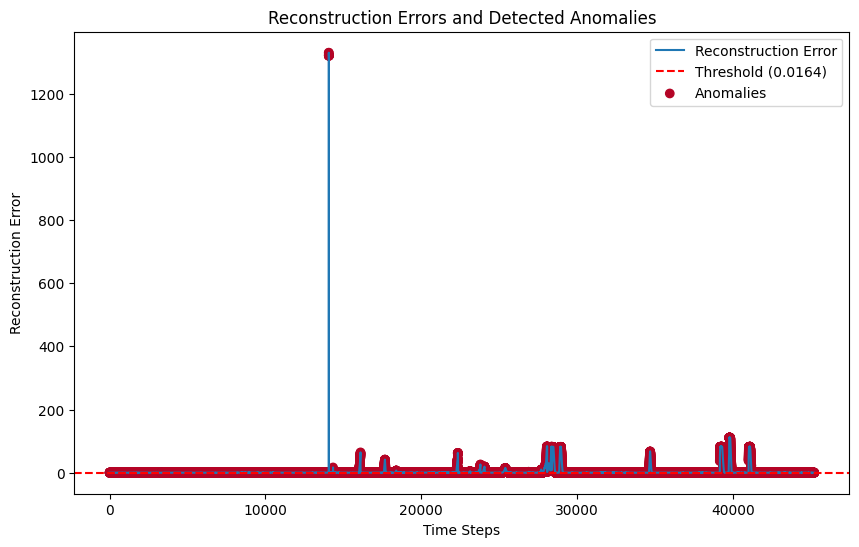

In [306]:
# Example usage for u5_s01_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_s01_turbine_data_preprocessed = preprocess_test_data(u5_s01_equil_turbine, u5_train_equil_turbine.columns, scaler)

ground_truth = u5_s01_equil_turbine['anomaly']  # Replace 'anomaly' with the actual column name

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_s01_turbine_data_preprocessed)

# Define anomaly scores and threshold
# Ensure reconstruction_errors and threshold are tensors
reconstruction_errors = torch.tensor(reconstruction_errors, dtype=torch.float32)
threshold = torch.tensor(threshold, dtype=torch.float32)

best_score = -float("inf")
best_threshold = 0

# Ensure ground_truth is a tensor
ground_truth = torch.tensor(u5_s01_equil_turbine['anomaly'].values, dtype=torch.int)

thresholds = torch.linspace(reconstruction_errors.min().item(), reconstruction_errors.max().item(), steps=100)
for th in thresholds:
    anomaly_scores = (reconstruction_errors > th).int()
    tp = ((anomaly_scores == 1) & (ground_truth == 1)).sum().item()
    fp = ((anomaly_scores == 1) & (ground_truth == 0)).sum().item()
    fn = ((anomaly_scores == 0) & (ground_truth == 1)).sum().item()
    tn = ((anomaly_scores == 0) & (ground_truth == 0)).sum().item()

    score = custom_score(tp, fp, fn, tn, penalty_fp=0.9)
    if score > best_score:
        best_score = score
        best_threshold = th.item()



print(f"Seuil optimal avec pénalité FP: {best_threshold:.4f}, Score: {best_score:.4f}")


anomaly_scores = define_anomaly_score(reconstruction_errors, best_threshold)
detected_anomalies = anomaly_scores  # Use the previously calculated anomaly scores
threshold = best_threshold  # Use the float value directly


# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


In [307]:
# Assuming `anomaly_scores` is already calculated in the previous cells
ground_truth = u5_s01_equil_turbine['anomaly']  # Replace 'anomaly' with the actual column name
detected_anomalies = anomaly_scores  # Use the previously calculated anomaly scores
accuracy = accuracy_score(ground_truth, detected_anomalies)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.66


In [308]:

# Assuming ground_truth is a binary array (1 for anomaly, 0 for normal) from the synthetic info file
# Replace 'anomaly' with the actual column name containing the labels
ground_truth = u5_s01_equil_turbine['anomaly'].values

# Detected anomalies (binary array where 1 indicates an anomaly and 0 indicates normal)
detected_anomalies = (reconstruction_errors > threshold).int()

# Calculate Precision, Recall, and F1-Score
precision = precision_score(ground_truth, detected_anomalies)
recall = recall_score(ground_truth, detected_anomalies)
f1 = f1_score(ground_truth, detected_anomalies)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Precision: 0.66
Recall: 1.00
F1-Score: 0.80


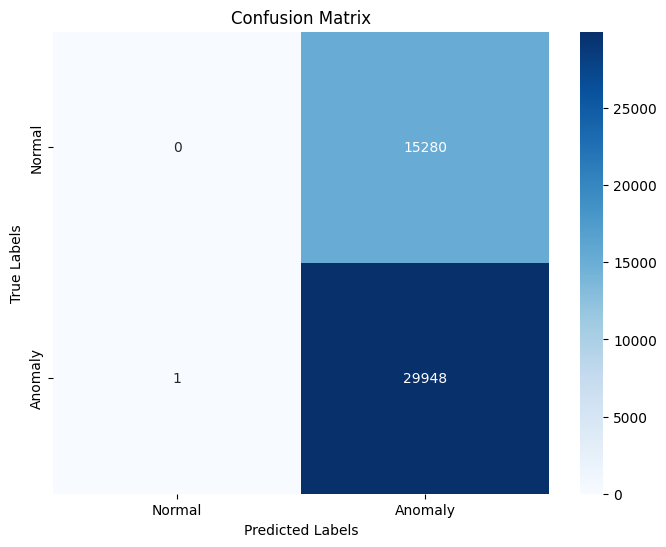

In [309]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(ground_truth, detected_anomalies)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


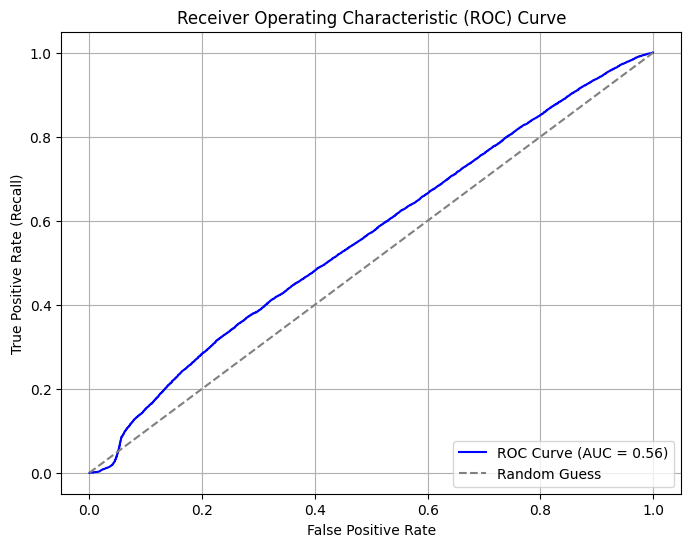

In [310]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(ground_truth, reconstruction_errors)
roc_auc = roc_auc_score(ground_truth, reconstruction_errors)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### for synthetic anomaly s02 :

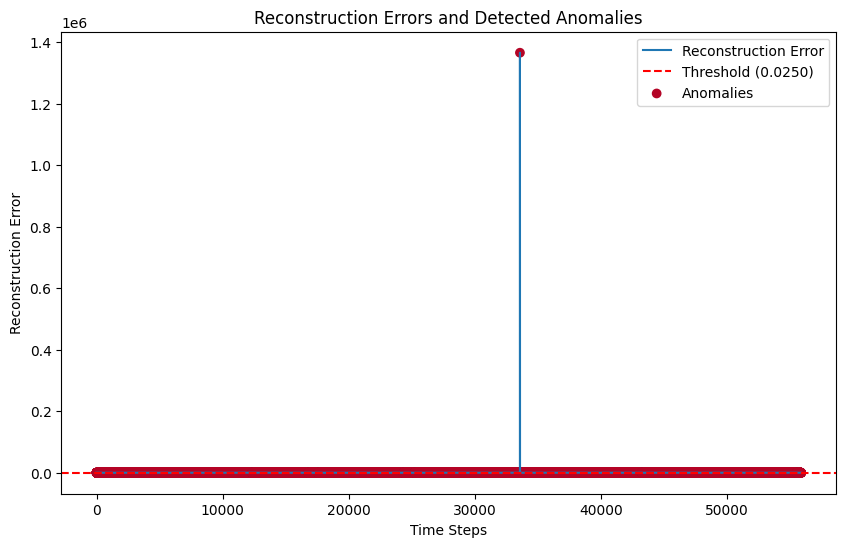

In [348]:
# Example usage for u5_s02_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_s02_turbine_data_preprocessed = preprocess_test_data(u5_s02_equil_turbine, u5_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_s02_turbine_data_preprocessed)

# Define anomaly scores and threshold
threshold = 0.025  # You can set this to an appropriate value or calculate it dynamically
anomaly_scores = define_anomaly_score(reconstruction_errors, threshold)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


In [349]:
# Assuming `anomaly_scores` is already calculated in the previous cells
ground_truth_u5_s02_T = u5_s02_equil_turbine['anomaly']  # Replace 'anomaly' with the actual column name
detected_anomalies_u5_s02_T = anomaly_scores  # Use the previously calculated anomaly scores
accuracy_u5_s02_T = accuracy_score(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)
print(f"Accuracy: {accuracy_u5_s02_T:.2f}")

Accuracy: 0.84


In [350]:

# Assuming ground_truth is a binary array (1 for anomaly, 0 for normal) from the synthetic info file
# Replace 'anomaly' with the actual column name containing the labels
ground_truth_u5_s02_T = u5_s02_equil_turbine['anomaly'].values

# Detected anomalies (binary array where 1 indicates an anomaly and 0 indicates normal)
detected_anomalies_u5_s02_T = (reconstruction_errors > threshold).int()

# Calculate Precision, Recall, and F1-Score
precision_u5_s02_T = precision_score(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)
recall_u5_s02_T = recall_score(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)
f1_u5_s02_T = f1_score(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)

print(f"Precision: {precision_u5_s02_T:.2f}")
print(f"Recall: {recall_u5_s02_T:.2f}")
print(f"F1-Score: {f1_u5_s02_T:.2f}")


Precision: 0.84
Recall: 1.00
F1-Score: 0.91


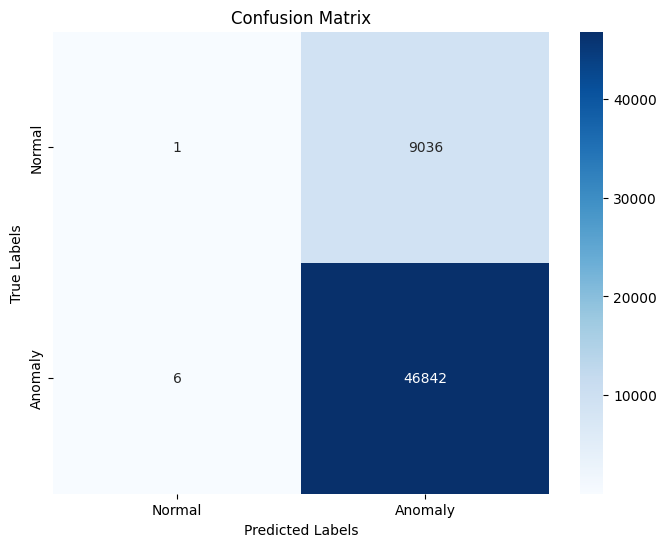

In [351]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(ground_truth_u5_s02_T, detected_anomalies_u5_s02_T)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


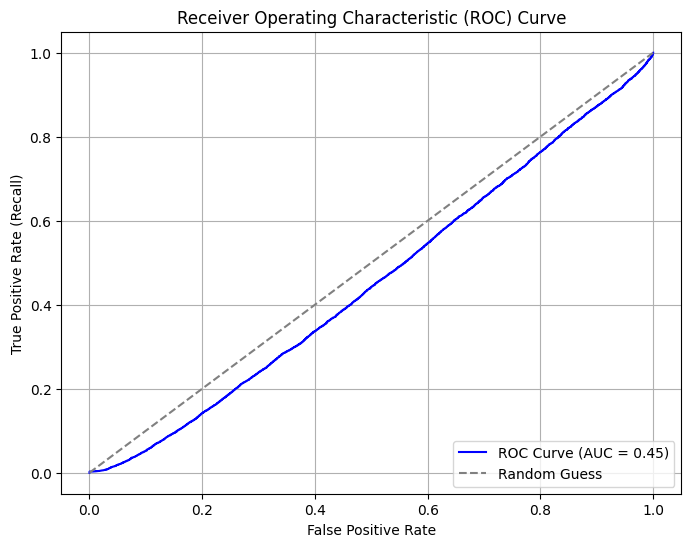

In [352]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(ground_truth_u5_s02_T, reconstruction_errors)
roc_auc = roc_auc_score(ground_truth_u5_s02_T, reconstruction_errors)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### for test anomalies : 

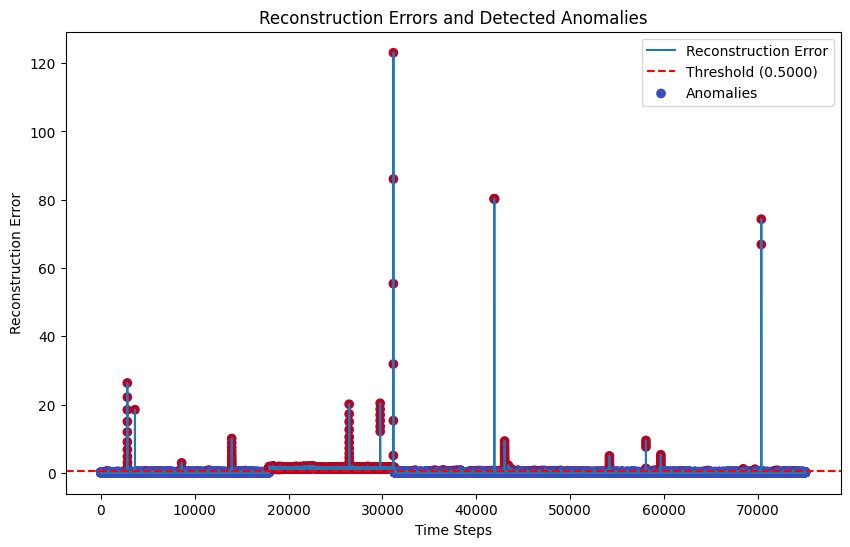

In [328]:
# Example usage for u5_test_equil_turbine
# Assume `u5_turbine_trained_model` is the autoencoder trained on u5_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u5_test_turbine_data_preprocessed = preprocess_test_data(u5_test_equil_turbine, u5_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_turbine_trained_model, u5_test_turbine_data_preprocessed)

# Define anomaly scores and threshold
threshold = 0.5  # You can set this to an appropriate value or calculate it dynamically
anomaly_scores = define_anomaly_score(reconstruction_errors, threshold)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


## for u5_train_equil_Pump 

In [ ]:
# Preprocess u5_train_equil_pump
u5_train_pump_data, scaler = preprocess_data_fast(u5_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u5_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u5_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

#### For Synthetic anomaly s01

In [ ]:
# Example usage for u5_s01_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_s01_pump_data_preprocessed = preprocess_test_data(u5_s01_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_s01_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for synthetic anomalies s02 : 

In [ ]:
# Example usage for u5_s02_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_s02_pump_data_preprocessed = preprocess_test_data(u5_s02_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_s02_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### For Test data set 

In [ ]:
# Example usage for u5_test_equil_pump
# Assume `u5_pump_trained_model` is the autoencoder trained on u5_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u5_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u5_test_pump_data_preprocessed = preprocess_test_data(u5_test_equil_pump, u5_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u5_pump_trained_model, u5_test_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


## For u6_train_equil_turbine

In [ ]:
# Preprocess u6_train_equil_turbine
u6_train_turbine_data, scaler = preprocess_data_fast(u6_train_equil_turbine)

# Train-validation split
train_tensor, val_tensor = train_test_split(u6_train_turbine_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u6_turbine_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

#### Synthetic anomaly s01 :

In [ ]:
# Example usage for u6_s01_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_s01_turbine_data_preprocessed = preprocess_test_data(u6_s01_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_s01_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### Synthetic anomaly s02 : 

In [ ]:
# Example usage for u6_s02_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_s02_turbine_data_preprocessed = preprocess_test_data(u6_s02_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_s02_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

#### For Test data set : 

In [ ]:
# Example usage for u6_test_equil_turbine
# Assume `u6_turbine_trained_model` is the autoencoder trained on u6_train_equil_turbine
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_turbine during training

# Ensure that the columns in the test data match the training data
u6_test_turbine_data_preprocessed = preprocess_test_data(u6_test_equil_turbine, u6_train_equil_turbine.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_turbine_trained_model, u6_test_turbine_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)

#### for u6_train_equil_pump

In [ ]:
# Preprocess u6_train_equil_pump
u6_train_pump_data, scaler = preprocess_data_fast(u6_train_equil_pump)

# Train-validation split
train_tensor, val_tensor = train_test_split(u6_train_pump_data, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_dim = train_tensor.shape[1]
model = FastAutoencoder(input_dim)
u6_pump_trained_model = train_autoencoder_fast(model, train_tensor, val_tensor)

#### for synthetic anomaly s01 : 

In [ ]:
# Example usage for u6_s01_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_s01_pump_data_preprocessed = preprocess_test_data(u6_s01_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_s01_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for synthetic anomaly s02 :

In [ ]:
# Example usage for u6_s02_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_s02_pump_data_preprocessed = preprocess_test_data(u6_s02_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_s02_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


#### for Test dataset: 


In [ ]:
# Example usage for u6_test_equil_pump
# Assume `u6_pump_trained_model` is the autoencoder trained on u6_train_equil_pump
# Assume `scaler` is the StandardScaler fitted to u6_train_equil_pump during training

# Ensure that the columns in the test data match the training data
u6_test_pump_data_preprocessed = preprocess_test_data(u6_test_equil_pump, u6_train_equil_pump.columns, scaler)

# Evaluate reconstruction errors
reconstruction_errors = evaluate_reconstruction(u6_pump_trained_model, u6_test_pump_data_preprocessed)

# Define anomaly scores and threshold
anomaly_scores, threshold = define_anomaly_score(reconstruction_errors)

# Visualize anomalies
visualize_anomalies(reconstruction_errors, anomaly_scores, threshold)


Tries with raw features...


In [ ]:
import matplotlib.pyplot as plt

# Define the time step of the anomaly and a window around it
anomaly_time_step = 10000  # Replace this with the actual index of the spike
window_size = 200  # Number of time steps before and after the anomaly
start_idx = max(0, anomaly_time_step - window_size)
end_idx = anomaly_time_step + window_size

# Extract the raw features from the test dataset
raw_features = u6_s01_equil_pump.iloc[start_idx:end_idx]  # Adjust the dataset name if necessary

# Plot raw features
plt.figure(figsize=(12, 8))
for column in raw_features.columns:
    plt.plot(raw_features.index, raw_features[column], label=column)

plt.title(f"Raw Sensor Data Around Anomaly at Time Step {anomaly_time_step}")
plt.xlabel("Time Steps")
plt.ylabel("Sensor Values")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.show()


#### identify significant features : 

In [ ]:
# Calculate feature-wise reconstruction error for the anomaly
def feature_reconstruction_error(raw_data, reconstruction):
    errors = (raw_data - reconstruction) ** 2  # Element-wise squared error
    mean_feature_errors = errors.mean(axis=0)  # Average error per feature
    return mean_feature_errors

# Assuming raw_features is already preprocessed as a tensor
reconstruction, _ = u6_pump_trained_model(u6_s01_pump_data_preprocessed)
feature_errors = feature_reconstruction_error(u6_s01_pump_data_preprocessed, reconstruction)

# Sort and display the most important features
significant_features = feature_errors.argsort(descending=True)[:5]  # Top 5 contributing features
print("Top Contributing Features:")
print(u6_s01_equil_pump.columns[significant_features])


In [ ]:
#Focus on those features : 

# Convert significant_features to a list of integers
significant_features = significant_features.tolist()

# Plot only the significant features
plt.figure(figsize=(12, 6))
for column in significant_features:
    plt.plot(raw_features.index, raw_features.iloc[:, column], label=raw_features.columns[column])

plt.title(f"Key Features Around Anomaly at Time Step {anomaly_time_step}")
plt.xlabel("Time Steps")
plt.ylabel("Sensor Values")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.show()


#### Let's plot all the water_circ_... : why ?I don't knw, but why not.... 

In [ ]:
# Define the anomaly time step and window size
anomaly_time_step = 10000  # Replace with the exact time step
narrow_window_size = 200  # Adjust if needed
start_idx = max(0, anomaly_time_step - narrow_window_size)
end_idx = anomaly_time_step + narrow_window_size

# Filter features with "water_circ_hot_" in their names
water_circ_hot_columns = [col for col in u6_s01_equil_pump.columns if "water_circ_hot_" in col]

# Extract data for these features within the specified time window
water_circ_hot_data = u6_s01_equil_pump.iloc[start_idx:end_idx][water_circ_hot_columns]

# Plot the features
plt.figure(figsize=(12, 6))
for col in water_circ_hot_columns:
    plt.plot(water_circ_hot_data.index, water_circ_hot_data[col], label=col)

plt.title(f"Water Circulation Hot Features Around Anomaly at Time Step {anomaly_time_step}")
plt.xlabel("Time Steps")
plt.ylabel("Sensor Values")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.show()
